In [1]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet,Variable, JITParticle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation 
import xarray as xr
import sys
sys.path.append('/scratch/jvalenti/OParcels_runs/Source')
from OP_functions import *

from IPython.display import Image
rc('animation', html='html5')

In [2]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    prefix = f'{path}/SalishSea_1{res}_{datestr}'
    return prefix
paths=path()

In [3]:
#Pick hour,day and location.
hour = 0
path_NEMO = make_prefix(datetime(2019, 1, 1),paths['NEMO'])
lati = 47.06327891719936
loni = -122.91039865193393
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]

#Specify some simulation parameters
T = 5e3 #s (run time)
dt = 5 #s (timestep)
N = 10e3 #number of particles
outputdt = 500 #s (how often do you want output?)
outputpath = '/home/jvalenti/MOAD/results/testmix.zarr'

In [5]:
j

5

In [4]:
def tu_mix(particle,fieldset,time):
    bath= 4 #! change to set up value
    if particle.depth+0.1 > bath: #Only calculate gradient of diffusion for particles deeper than 0.6 otherwise OP will check for particles outside the domain and remove it.
        Kzdz = 10*(fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-0.1,particle.lat, particle.lon]) #forward difference 
    else: 
        Kzdz = 10*(fieldset.Kz[time,particle.depth+0.1,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #forward difference 
    dgrad = Kzdz * particle.dt 
    if particle.depth+0.5*dgrad > 0 and particle.depth+0.5*dgrad < bath:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad,particle.lat, particle.lon] #Vertical diffusivity SSC  #
    else:
        kk = fieldset.Kz[time, particle.depth,particle.lat, particle.lon] #Vertical diffusivity SSC  #
    Rr = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    dzs = d_random +dgrad

def Buoyancy(particle, fieldset, time):
    """Calculating settling velocity using Komar cylinder Vs"""
#Check particle is in the water column   
    d = 2.16e-5 # particle diameter
    l = 4.5e-4 # particle length
    g = 9.8 #Gravity
    visc = 1e-3
    Ws= ((l/d)**-1.664)*0.079*((l**2)*g*(1350-1025))/(visc)
    dws = Ws*particle.dt

def displacement(particle, fieldset, time):
    if dzs +particle.depth + dws > bath: #randomly in the water column
        particle.depth = 2*bath - (dzs +particle.depth+dws)
    elif dzs +particle.depth +dws < 0:
        particle.depth = -(dzs +particle.depth+dws) #Well mixed boundary layer
    else:
        particle.depth += dzs + dws

In [5]:
i = 304
j = 352

In [6]:
#Load data from NEMO
Wdat = xr.open_dataset(path_NEMO+'_grid_W.nc', decode_times=False)
mbathy = xr.open_dataset('/home/jvalenti/scratch/OParcels_runs/grid/mesh_mask202108_TDV.nc').mbathy[0,j,i].item()
depth = np.array(Wdat.depthw[:mbathy+1]).astype('float32')
Kz_col = np.array(Wdat.vert_eddy_diff[hour,:mbathy+1,j,i]).astype('float32')
#Kz_col[0]=Kz_col[1]

In [7]:
Kz_col

array([0.0000000e+00, 1.4839052e-04, 3.9876439e-04, 4.0547430e-04,
       7.0983346e-04, 5.6266453e-04, 9.2508167e-04, 1.6843861e-03,
       1.7160808e-03, 9.8250399e-05, 2.9757267e-04, 4.8334079e-04,
       1.1465645e-04, 6.2521937e-04, 1.0954147e-03, 1.6632305e-04,
       1.9175188e-05, 3.5658235e-05, 4.1416621e-05, 4.5118722e-04,
       3.7818254e-04, 3.6501213e-05, 1.0000000e-06, 1.0000000e-06,
       1.0848702e-06, 7.3366144e-05, 8.5051538e-04, 1.5845570e-04,
       3.1806511e-04, 1.6327577e-03, 5.9822559e-02, 1.7562917e-02,
       0.0000000e+00], dtype=float32)

In [87]:
dim = 10
R = 0.5
L = depth[-1]
dimz = len(depth)
lon = np.linspace(0., R*2, dim, dtype=np.float32)

U = Field('U', np.zeros((dimz, dim), dtype=np.float32), lon=lon, depth=depth)
V = Field('V', np.zeros((dimz, dim), dtype=np.float32), lon=lon, depth=depth)
Kz_data = np.zeros((dimz, dim), dtype=np.float32)
for i in range(dim):
    Kz_data[:,i]=Kz_col
Kz = Field('Kz', Kz_data, grid=U.grid)

In [88]:
fieldset = FieldSet(U,V)
fieldset.add_field(Kz)

In [89]:
Vol = 2*R*L
C0 = 0.1
n = int(C0*Vol * 1000)
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(n,))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(n,))
lat_g = np.zeros(n,)
len(lat_g)

400

In [90]:
TL = int(L/0.000326)
step = int(TL/100)

In [91]:
pset = ParticleSet(fieldset, pclass=JITParticle, lon=lon_g, depth=depth_g,lat = lat_g)
output_file = pset.ParticleFile(name='/scratch/jvalenti/OParcels_runs/mixing_watercolumn.zarr', outputdt=step )
pset.execute([tu_mix,Buoyancy,displacement] , runtime=TL, dt=5, output_file=output_file)

  0%|          | 5.0/12270.0 [00:47<32:41:13,  9.59s/it]
INFO: Output files are stored in /scratch/jvalenti/OParcels_runs/mixing_watercolumn.zarr.
  1%|          | 127.0/12270.0 [00:01<02:30, 80.76it/s]

100%|██████████| 12270.0/12270.0 [01:11<00:00, 171.85it/s]


In [92]:
dat = xr.load_dataset('/scratch/jvalenti/OParcels_runs/mixing_watercolumn.zarr')

/home/jvalenti/miniforge3/envs/Parcels_24/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/miniforge3/envs/Parcels_24/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [93]:
def anim2(file1,fps=1):  
    box=([0,1,1,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,3,figsize=(15,10))
    axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    axs[2].plot(Kz_col,depth,c='r')
    axs[2].set_title('Vertical profile $K_z$ [$m^2/s$]')
    axs[2].invert_yaxis()
    axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    axs[1].plot(box[0],box[1],c='grey',linewidth=3)
    axs[0].invert_yaxis()
    axs[0].set_title('Initial condition (t: 0s)')
    axs[1].invert_yaxis()
    axs[1].set_title("With $K_z$' correction (t: 5*$10^3$s)")
    axs[0].set_ylabel('Depth (m)')

    def update(frame):         
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]                    
        ss.append(axs[1].scatter(file1.lon[:,frame],file1.z[:,frame],s=5,c ='tab:blue'))    
        print(f'{frame*100/file1.lon.shape[1]:.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,file1.lon.shape[1],fps))

0.00% completed
0.00% completed
0.99% completed
1.98% completed
2.97% completed
3.96% completed
4.95% completed
5.94% completed
6.93% completed
7.92% completed
8.91% completed
9.90% completed
10.89% completed
11.88% completed
12.87% completed
13.86% completed
14.85% completed
15.84% completed
16.83% completed
17.82% completed
18.81% completed
19.80% completed
20.79% completed
21.78% completed
22.77% completed
23.76% completed
24.75% completed
25.74% completed
26.73% completed
27.72% completed
28.71% completed
29.70% completed
30.69% completed
31.68% completed
32.67% completed
33.66% completed
34.65% completed
35.64% completed
36.63% completed
37.62% completed
38.61% completed
39.60% completed
40.59% completed
41.58% completed
42.57% completed
43.56% completed
44.55% completed
45.54% completed
46.53% completed
47.52% completed
48.51% completed


49.50% completed
50.50% completed
51.49% completed
52.48% completed
53.47% completed
54.46% completed
55.45% completed
56.44% completed
57.43% completed
58.42% completed
59.41% completed
60.40% completed
61.39% completed
62.38% completed
63.37% completed
64.36% completed
65.35% completed
66.34% completed
67.33% completed
68.32% completed
69.31% completed
70.30% completed
71.29% completed
72.28% completed
73.27% completed
74.26% completed
75.25% completed
76.24% completed
77.23% completed
78.22% completed
79.21% completed
80.20% completed
81.19% completed
82.18% completed
83.17% completed
84.16% completed
85.15% completed
86.14% completed
87.13% completed
88.12% completed
89.11% completed
90.10% completed
91.09% completed
92.08% completed
93.07% completed
94.06% completed
95.05% completed
96.04% completed
97.03% completed
98.02% completed
99.01% completed
0.00% completed


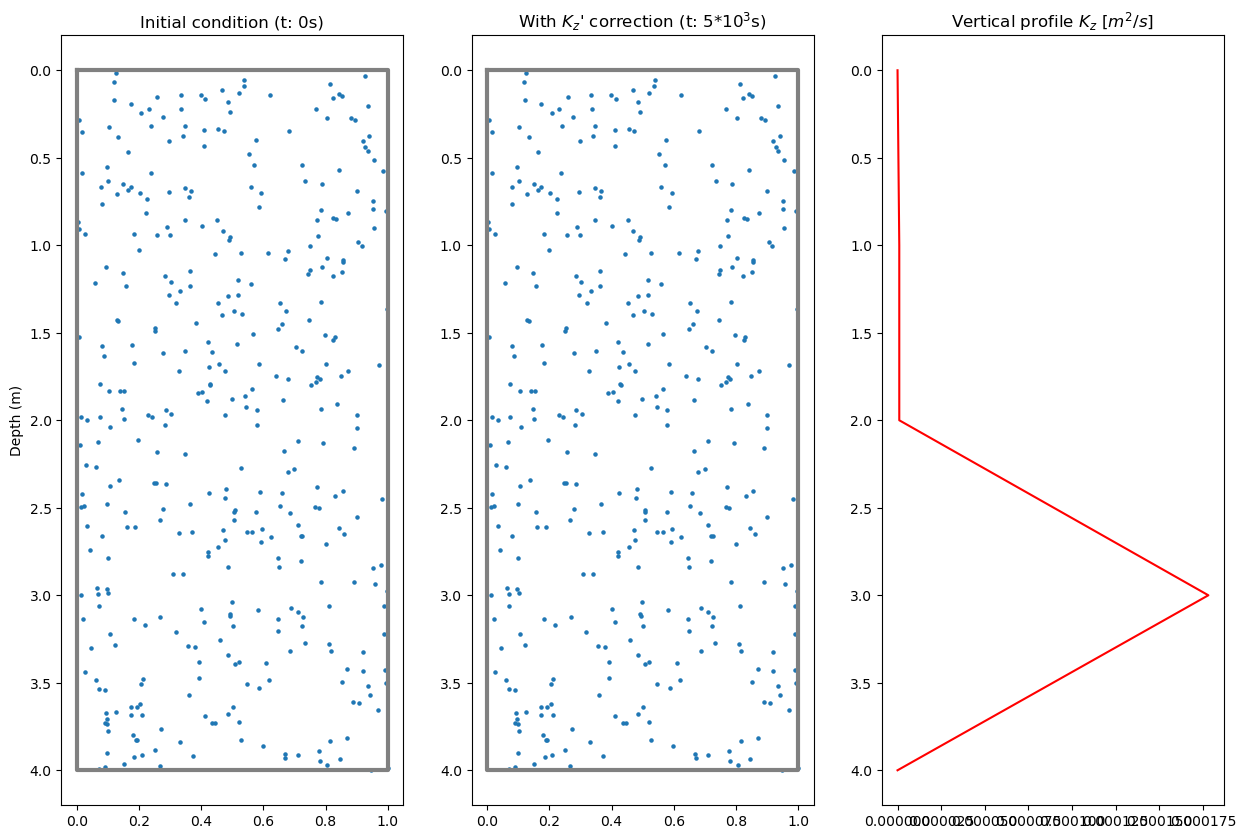

In [94]:
ss =[]
ani = anim2(dat,fps=1)
f = r"/scratch/jvalenti/OParcels_runs/mix.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

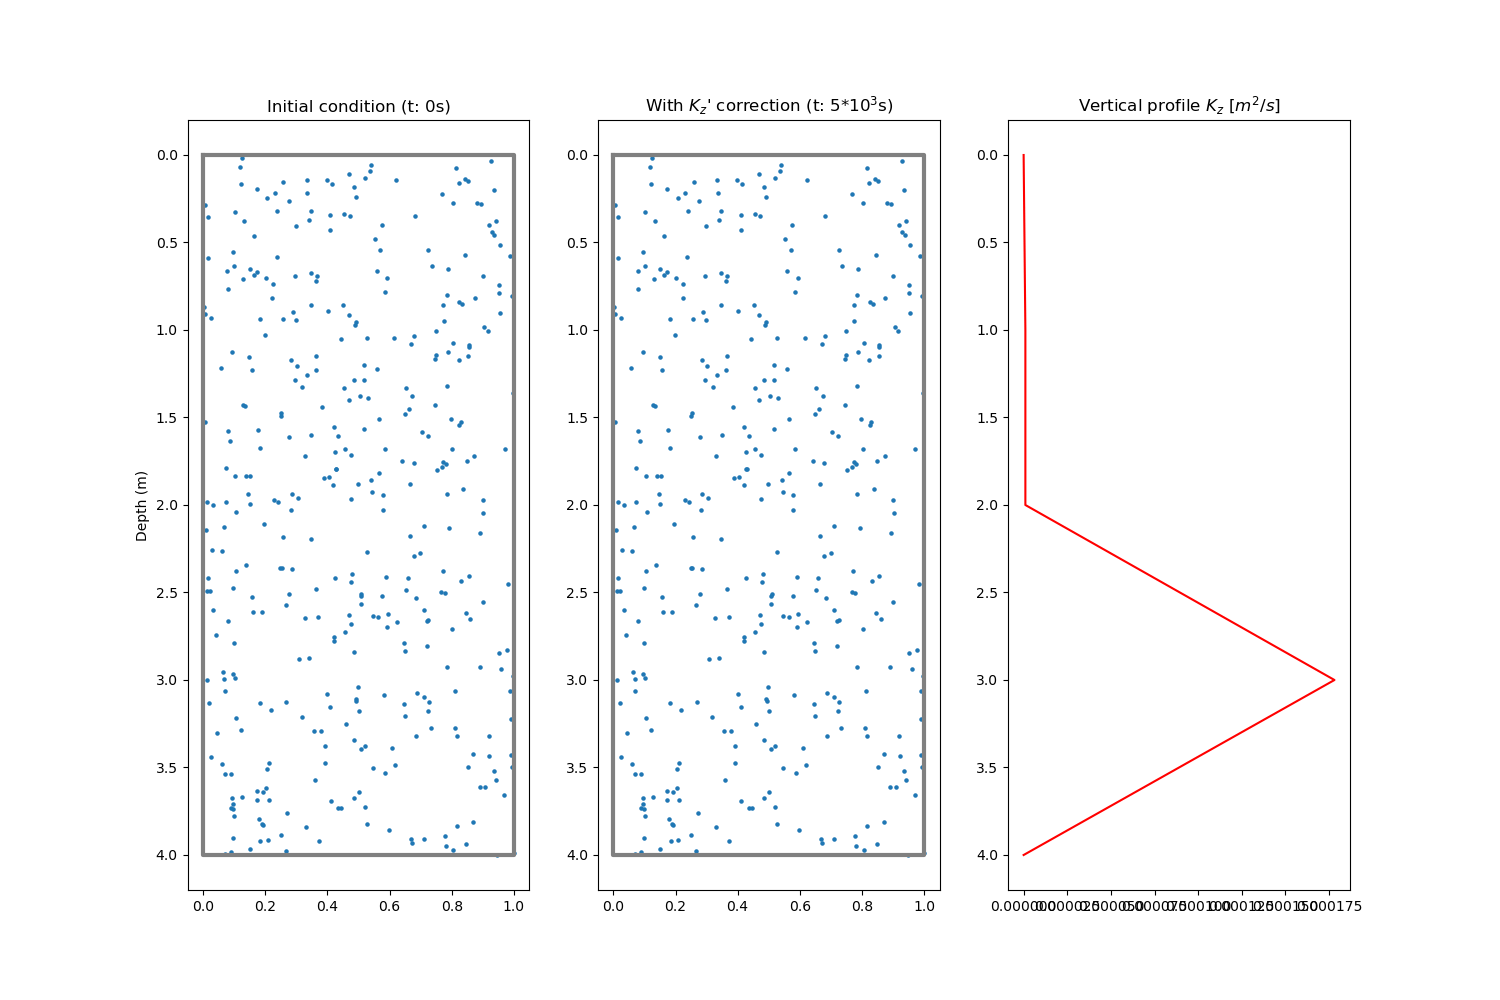

In [95]:
with open(f,'rb') as anim:
     display(Image(anim.read()))

In [96]:
def anim3(file1,fps=1):  
    #box=([0,1,1,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,1,figsize=(5,5))
    #axs.plot(box[0],box[1],c='grey',linewidth=3)
    #axs.invert_yaxis()

    def update(frame):         
        global ss        
        axs.clear()     
        counts, bins = np.histogram(file1.z[:,frame], bins = 10)
        axs.stairs(counts, bins)
        print(f'{frame*100/file1.lon.shape[1]:.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,file1.lon.shape[1],fps))

0.00% completed
0.00% completed
0.99% completed
1.98% completed
2.97% completed
3.96% completed
4.95% completed
5.94% completed
6.93% completed
7.92% completed
8.91% completed
9.90% completed
10.89% completed
11.88% completed
12.87% completed
13.86% completed
14.85% completed
15.84% completed
16.83% completed
17.82% completed
18.81% completed
19.80% completed
20.79% completed
21.78% completed


22.77% completed
23.76% completed
24.75% completed
25.74% completed
26.73% completed
27.72% completed
28.71% completed
29.70% completed
30.69% completed
31.68% completed
32.67% completed
33.66% completed
34.65% completed
35.64% completed
36.63% completed
37.62% completed
38.61% completed
39.60% completed
40.59% completed
41.58% completed
42.57% completed
43.56% completed
44.55% completed
45.54% completed
46.53% completed
47.52% completed
48.51% completed
49.50% completed
50.50% completed
51.49% completed
52.48% completed
53.47% completed
54.46% completed
55.45% completed
56.44% completed
57.43% completed
58.42% completed
59.41% completed
60.40% completed
61.39% completed
62.38% completed
63.37% completed
64.36% completed
65.35% completed
66.34% completed
67.33% completed
68.32% completed
69.31% completed
70.30% completed
71.29% completed
72.28% completed
73.27% completed
74.26% completed
75.25% completed
76.24% completed
77.23% completed
78.22% completed
79.21% completed
80.20% complet

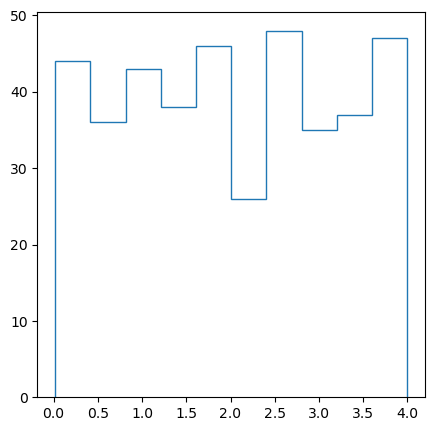

In [97]:
ss =[]
ani = anim3(dat,fps=1)
f = r"/scratch/jvalenti/OParcels_runs/bins.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

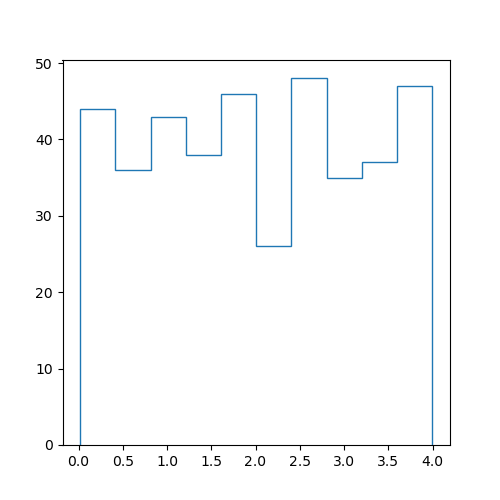

In [98]:
with open(f,'rb') as anim:
     display(Image(anim.read()))